# Tarea 2: redes convolucionales y transferencia
## Curso de aprendizaje profundo

## PCIC, UNAM

Resuelve los siguientes ejercicios en libretas de Colab que sean replicables. Sugerencias: probar tasas de aprendizaje bajas [10−3, 10^−4], usar una arquitectura eficiente, cuidar el congelado de parámetros/estadísticas, usar GPU, encapsular y parametrizar funciones de entrenamiento.

# 1. Operación de convolución (2 pts)
Extiende la operación de convolución para imágenes en escala de grises (un solo canal) vista en clase (https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/2a_convolucion.ipynb) a imágenes a color (múltiples canales).

## Convolución

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

### Carga conjunto de datos de dígitos
Vamos a cargar el conjunto de datos de díogitos usando la biblioteca `scikit-learn`:

In [ ]:
digits = load_digits()
data = digits.images
labels = digits.target

In [ ]:
data[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Es conveniente normalizar los valores de las imágenes para que estén en el mismo rango ($0-1$).

In [ ]:
data = data / data.max()

In [ ]:
data[0]

array([[0.    , 0.    , 0.3125, 0.8125, 0.5625, 0.0625, 0.    , 0.    ],
       [0.    , 0.    , 0.8125, 0.9375, 0.625 , 0.9375, 0.3125, 0.    ],
       [0.    , 0.1875, 0.9375, 0.125 , 0.    , 0.6875, 0.5   , 0.    ],
       [0.    , 0.25  , 0.75  , 0.    , 0.    , 0.5   , 0.5   , 0.    ],
       [0.    , 0.3125, 0.5   , 0.    , 0.    , 0.5625, 0.5   , 0.    ],
       [0.    , 0.25  , 0.6875, 0.    , 0.0625, 0.75  , 0.4375, 0.    ],
       [0.    , 0.125 , 0.875 , 0.3125, 0.625 , 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.375 , 0.8125, 0.625 , 0.    , 0.    , 0.    ]])

Este conjuntos de datos está compuesto por imágenes de $8 \times 8$ de los dígitos $0-9$. Visualicemos 2 instancias de los dígitos $0$ y $7$:

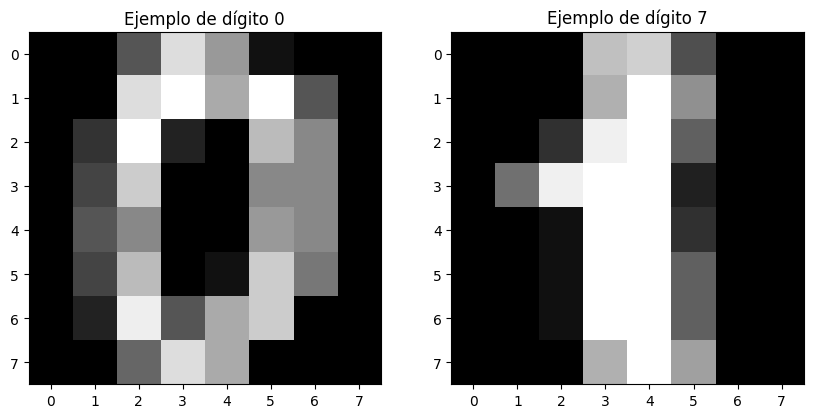

In [ ]:
imagen0 = data[labels == 0][0]
imagen1 = data[labels == 1][0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(imagen0, cmap = 'gray')
axs[0].set_title('Ejemplo de dígito 0')
axs[1].imshow(imagen1, cmap = 'gray')
axs[1].set_title('Ejemplo de dígito 7')
plt.show()

### Convolución y correlación cruzada
Ahora consideremos las operación de convolución entre una imagen $I$ y un filtro $W$, la cual está definida por

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n}
$$

En lugar de la convolución, frecuentemente se ocupa la operación de correlación cruzada para llevar a cabo las capas convolucionales. Esta operación es similar a la convolución pero sin voltear el filtro (por lo que pierde la propiedad de conmutatividad) y está dada por

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i + m, j + n} W_{m,n}
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$.



In [ ]:
def conv2d(I, W, b, stride = 1):
  h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
  a = np.zeros((h_s, w_s))
  for i in range(h_s):
    for j in range(w_s):
      I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1]]
      a[i, j] = (I_m * W).sum() + b

  return a

### Filtro

Definamos un filtro de $3 \times 3$ que detecte bordes en cierta orientación:

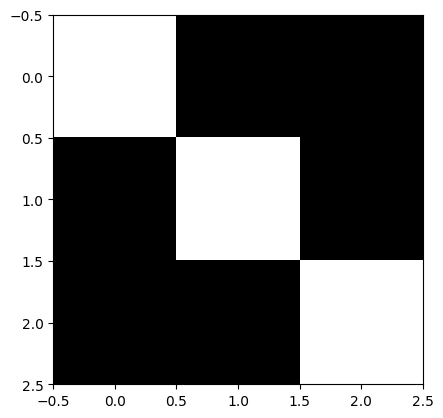

In [ ]:
filter1 = np.zeros((3,3))
np.fill_diagonal(filter1, np.array([1, 1, 1]))
plt.imshow(filter1 * 0.5 + 0.5, cmap = 'gray')
plt.show()

Definimos la función sigmoide:

In [ ]:
sigmoid = lambda z: 1. / (1. + np.exp(-z))

Aplicando las operaciones de correlación cruzada y convolución de una imagen del dígito $0$ con dicho filtro y al revés obtenemos:

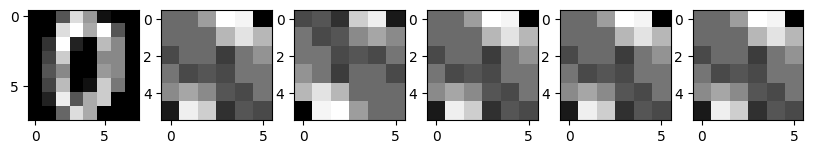

In [ ]:
from scipy.signal import correlate2d, convolve2d

ccorr = sigmoid(correlate2d(imagen0, filter1, mode = 'valid'))
ccorr2 = sigmoid(correlate2d(filter1, imagen0, mode = 'valid'))

conv = sigmoid(convolve2d(imagen0, filter1, mode = 'valid'))
conv2 = sigmoid(convolve2d(filter1, imagen0, mode = 'valid'))

a = sigmoid(conv2d(imagen0, filter1, 0))

fig, axs = plt.subplots(1, 6, figsize=(10, 5))
axs[0].imshow(imagen0, cmap = 'gray')
axs[1].imshow(ccorr, cmap = 'gray')
axs[2].imshow(ccorr2, cmap = 'gray')
axs[3].imshow(conv, cmap = 'gray')
axs[4].imshow(conv2, cmap = 'gray')
axs[5].imshow(a, cmap = 'gray')
plt.show()

Observa que el resultado de la correlación cruzada de la imagen con el filtro es diferente al del filtro con la imagen. En contraste, la convolución es conmutativa y produce el mismo resultado en ambos casos.

Haciendo lo mismo para una imagen del dígito $1$:

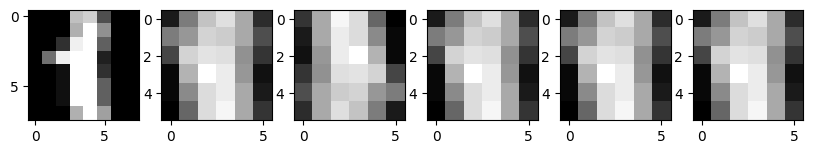

In [ ]:
ccorr = sigmoid(correlate2d(imagen1, filter1, mode = 'valid'))
ccorr2 = sigmoid(correlate2d(filter1, imagen1, mode = 'valid'))

conv = sigmoid(convolve2d(imagen1, filter1, mode = 'valid'))
conv2 = sigmoid(convolve2d(filter1, imagen1, mode = 'valid'))

a = sigmoid(conv2d(imagen1, filter1, 0))

fig, axs = plt.subplots(1, 6, figsize=(10, 5))
axs[0].imshow(imagen1, cmap = 'gray')
axs[1].imshow(ccorr, cmap = 'gray')
axs[2].imshow(ccorr2, cmap = 'gray')
axs[3].imshow(conv, cmap = 'gray')
axs[4].imshow(conv2, cmap = 'gray')
axs[5].imshow(a, cmap = 'gray')
plt.show()

Podemos definir otros filtros de $3\times 3$:

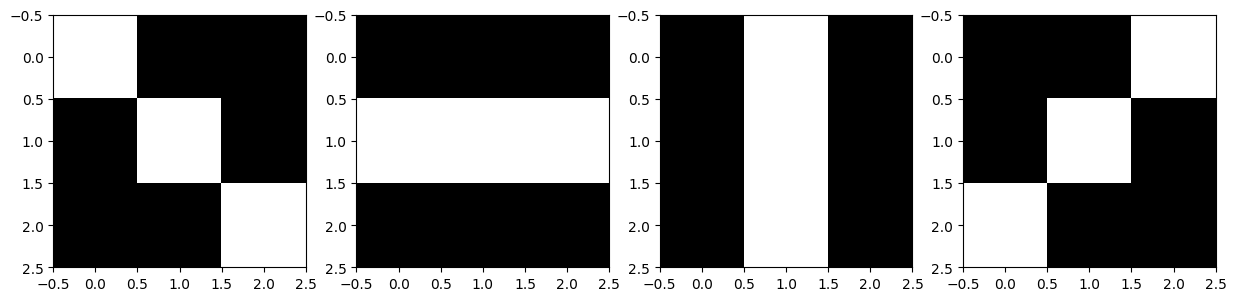

In [ ]:
filters = np.zeros((4, 3, 3))
filters[0, :, :] = filter1
filters[1, 1, :] = 1
filters[2, :, 1] = 1
filters[3, :, :] = filter1[::-1]

b = np.zeros(filters.shape[0])

f, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
for i in range(filters.shape[0]):
  axs[i].imshow(filters[i], cmap = 'gray')
plt.show()

Para aplicar la operación de convolución con cada uno de estos filtros definimos la siguiente función:

In [ ]:
def multi_conv2d(I, W, b, stride = 1):
  k = W.shape[0]
  activations = []
  for i in range(k):
    activations.append(conv2d(I, W[i], b[i], stride = 1))

  return np.array(activations)

Evaluamos esta función con cuatro distintos filtros para nuestras dos imágenes, obteniendo cuatro mapas de activaciones por cada imagen.

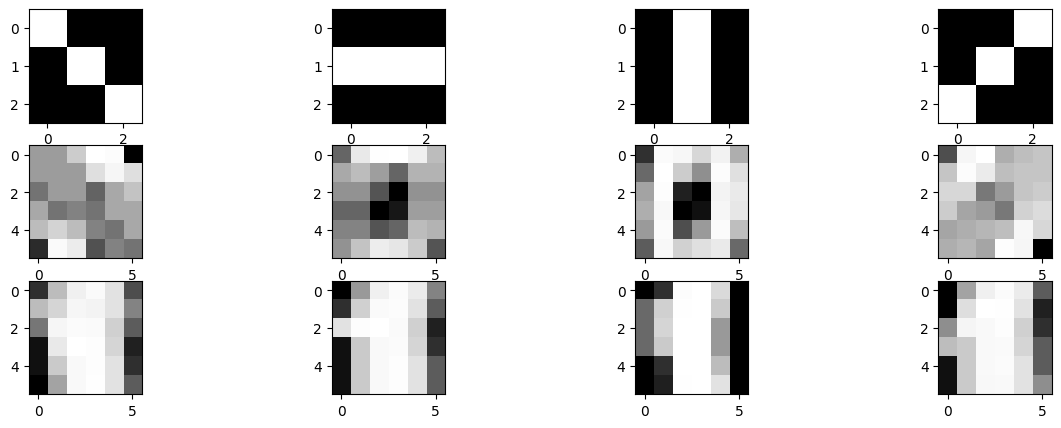

In [ ]:
activations_0 = np.tanh(multi_conv2d(imagen0, filters, b))
activations_1 = np.tanh(multi_conv2d(imagen1, filters, b))

f, axs = plt.subplots(nrows=3, ncols=4, figsize=(15,5))
for i in range(filters.shape[0]):
  axs[0, i].imshow(filters[i], cmap = 'gray')
  axs[1, i].imshow(activations_0[i], cmap = 'gray')
  axs[2, i].imshow(activations_1[i], cmap = 'gray')
plt.show()

Ahora definimos funciones para realizar un submuestreo máximo a un conjunto de mapas de características:

In [ ]:
def submuestreo_maximo(activations, block = (2,2)):
  H, W = activations.shape
  H_s = H // block[0]
  W_s = W // block[1]

  sub_a = np.zeros((H_s,W_s))
  max_x = activations.reshape((H * W_s, block[1])).max(axis = 1)
  sub_a = max_x.T.reshape((W_s, block[0], H_s)).max(axis = 1)

  return sub_a

def multi_submuestreo_maximo(activations, block = (2,2)):
  k = activations.shape[0]
  sub_a = []
  for i in range(k):
    sub_a.append(submuestreo_maximo(activations[i]))

  return np.array(sub_a)

Aplicamos el submuestreo a nuestros mapas de activaciones

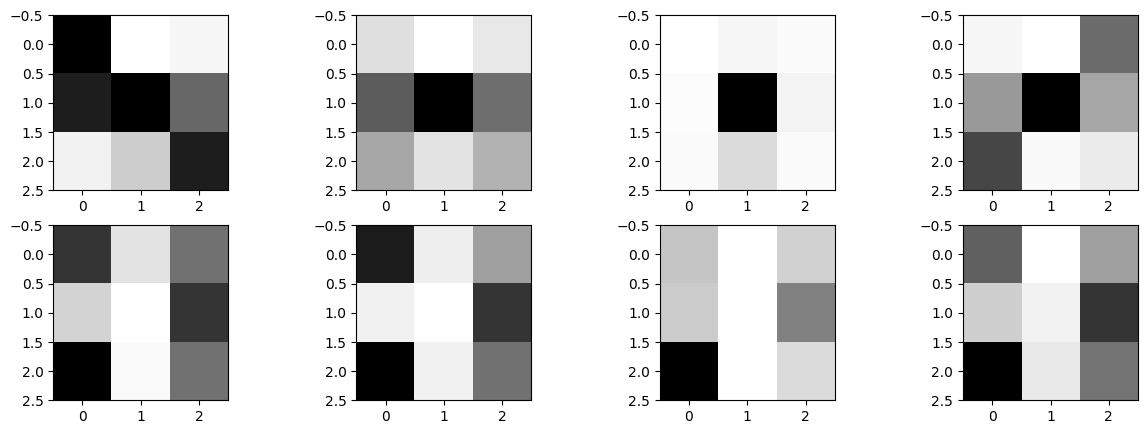

In [ ]:
sub_a0 = multi_submuestreo_maximo(activations_0)
sub_a1 = multi_submuestreo_maximo(activations_1)

f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
for i in range(filters.shape[0]):
  axs[0, i].imshow(sub_a0[i], cmap = 'gray')
  axs[1, i].imshow(sub_a1[i], cmap = 'gray')
plt.show()

## Implementación de convolución 3D (imagenes a color)

In [ ]:
def conv2d_color(I, W, b, stride=1):
    h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
    w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
    num_channels = I.shape[2]  # Número de canales en la imagen de entrada
    a = np.zeros((h_s, w_s))

    for i in range(h_s):
        for j in range(w_s):
            I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1], :]
            # Realiza la convolución en cada canal por separado
            conv_result = np.sum(I_m * W, axis=(0, 1))
            a[i, j] = np.sum(conv_result) + b

    return a


In [ ]:
import numpy as np

# Crear una imagen en color de ejemplo (3 canales)
image = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                  [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                  [[19, 20, 21], [22, 23, 24], [25, 26, 27]]], dtype=np.float32)

# Crear un filtro de convolución de ejemplo (3x3x3)
kernel = np.array([[[1, 0, -1], [2, 0, -2], [1, 0, -1]],
                   [[1, 0, -1], [2, 0, -2], [1, 0, -1]],
                   [[1, 0, -1], [2, 0, -2], [1, 0, -1]]], dtype=np.float32)

# Definir un valor de sesgo de ejemplo
bias = 1.0

# Probar la función de convolución
result = conv2d_color(image, kernel, bias)

print("Resultado de la convolución:")
print(result)


Resultado de la convolución:
[[-23.]]


Probaremos nuestras funciones:

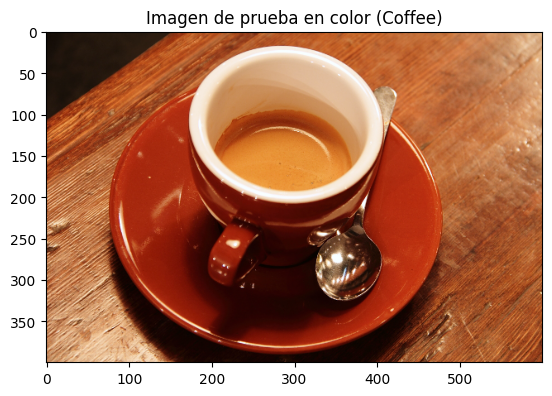

In [ ]:
from skimage import data

# Cargar una imagen en color de prueba (por ejemplo, la imagen de coffee)
image = data.coffee()/255

# Visualizar la imagen
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title("Imagen de prueba en color (Coffee)")
plt.show()


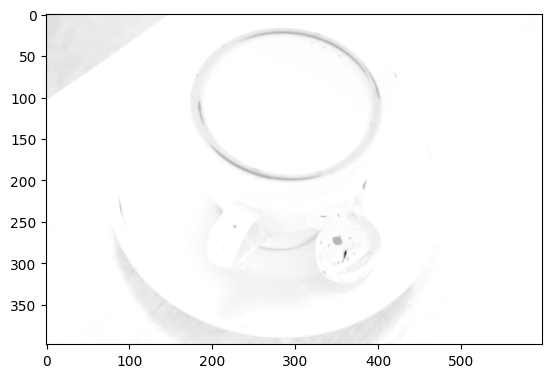

In [ ]:

conv = sigmoid(conv2d_color(image, kernel, 2.0))
#conv2 = sigmoid(conv2d_color(filter1, image, bias))

#a = sigmoid(conv2d(image, filter1, 0))

plt.imshow(conv, cmap = 'gray')


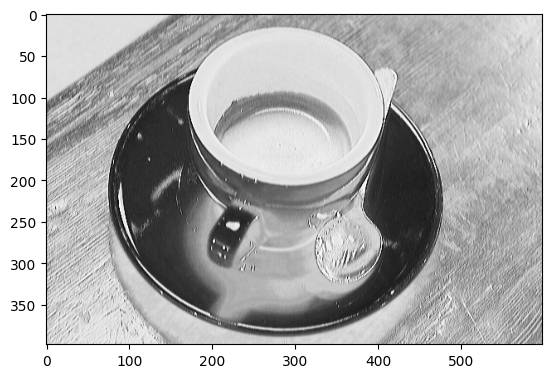

In [ ]:
# probemos otro kernel
# Definir un kernel de convolución 2x2
kernel2 = np.array([[-1, -1, -1],
                  [-1,  8, -1],
                  [-1, -1, -1]])


conv = sigmoid(conv2d_color(image, kernel2, 2.0))
#conv2 = sigmoid(conv2d_color(filter1, image, bias))

#a = sigmoid(conv2d(image, filter1, 0))

plt.imshow(conv, cmap = 'gray')


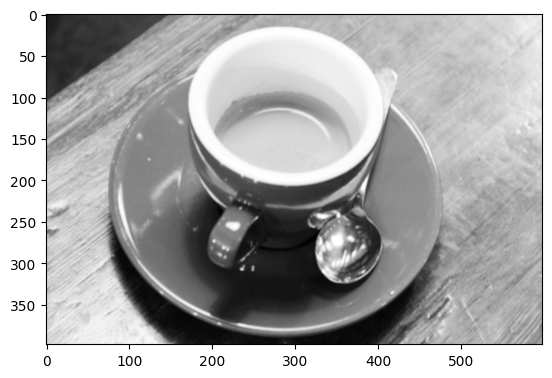

In [ ]:
# Definir un kernel de convolución Gaussiano 3x3
kernel_gaussiano = np.array([[1, 2, 1],
                             [2, 4, 2],
                             [1, 2, 1]])

# Normalizar el kernel para que la suma de sus valores sea 1
kernel_gaussiano = kernel_gaussiano/np.sum(kernel_gaussiano)

conv = sigmoid(conv2d_color(image, kernel_gaussiano, 2.0))


plt.imshow(conv, cmap = 'gray')



# 2. Clasificación de rostros por grupo etario

Entrena y evalúa modelos de clasificación de rostros por grupo etario usando el conjunto de
datos FairFace. Para ello, deberás:

* Dividir aleatoriamente el conjunto de entrenamiento
en subconjuntos de entrenamiento y validación y usar el conjunto de validación como prueba.

# Preparación

## Instalaciones

In [ ]:
!pip install dlib
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

In [ ]:
!pip install torch

In [ ]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade torch torchvision


## Bibliotecas

In [ ]:
#### Bibliotecas

# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
import torch as th
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

#optimizador
from torch.optim import Adam


## Directorios y funciones útiles

In [ ]:
# directorio de datos
base_dir = '/home/carmen/DL'
filename = 'fairface-img-margin025-trainval.zip'
data_dir = '/home/carmen/DL/fairface'
filepath = os.path.join(base_dir, filename)


LOGDIR = 'logs/'
device = 'cuda:0' if th.cuda.is_available() else 'cpu'

# tamaño del lote
BATCH_SIZE =  32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x = (x * 255)
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    #x = x.transpose(1, 2, 3, 0)
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    #print('aqui ', x.shape)
    display_grid(x, titles, rows, cols, figsize)



def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
th.manual_seed(0)
np.random.seed(0)

## Preparación de datos

In [ ]:
# desempaquetemos las imagenes
#!unzip {filepath} -d {base_dir}

# 2 Conjunto de datos

## 2.1 Preparando data frames

In [ ]:

#el conjunto de datos se encuentra dividido en subconjuntos de entrenamiento y prueba, los cuales están contenidos en los directorios train y test

train_path_csv = os.path.join(data_dir, 'fairface_label_train.csv')
test_path_csv = os.path.join(data_dir, 'fairface_label_val.csv')

df_train = df = pd.read_csv(train_path_csv)
df_test =  pd.read_csv(test_path_csv)

In [ ]:
# Obtenemos una lista de nombres de archivos en el directorio 'train' dentro de 'data_dir'.
files = os.listdir(os.path.join(data_dir, 'train'))

# Obtenemos una lista de nombres de archivos en el directorio 'val' dentro de 'data_dir'.
files2 = os.listdir(os.path.join(data_dir, 'val'))

# Creamos un diccionario 'ind_a_str' que mapea índices a edades únicas en el DataFrame 'df'.
# Los índices son generados automáticamente y representan las edades únicas como cadenas.
ind_a_str = {i: s for i, s in enumerate(df.age.unique())}

# Creamos un diccionario 'str_a_ind' que mapea edades únicas en el DataFrame 'df' a sus índices correspondientes.
# Esto facilita la búsqueda de índices cuando se conoce la edad en forma de cadena.
str_a_ind = {s: i for i, s in enumerate(df.age.unique())}


In [ ]:
ind_a_str

{0: '50-59',
 1: '30-39',
 2: '3-9',
 3: '20-29',
 4: '40-49',
 5: '10-19',
 6: '60-69',
 7: '0-2',
 8: 'more than 70'}

## 2.2 Clase para FairFace

In [ ]:
class FairFace:
    def __init__(self,
                csv,
                raiz,
                transform = None):
      self.df = pd.read_csv(csv)
      self.raiz = raiz
      self.transform = transform

    def __getitem__(self, i):
      path = os.path.join(data_dir, self.df['file'].iloc[i])
      img = Image.open(path)

      cat = self.df['age'].iloc[i]
      y = np.array(str_a_ind[cat], np.float32).reshape(1)

      if self.transform:
        img = self.transform(img)


      return img, y.squeeze()

    def __len__(self):
      # número de ejemplos en el conjunto
      return len(self.df)

## 2.3 Exploración

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


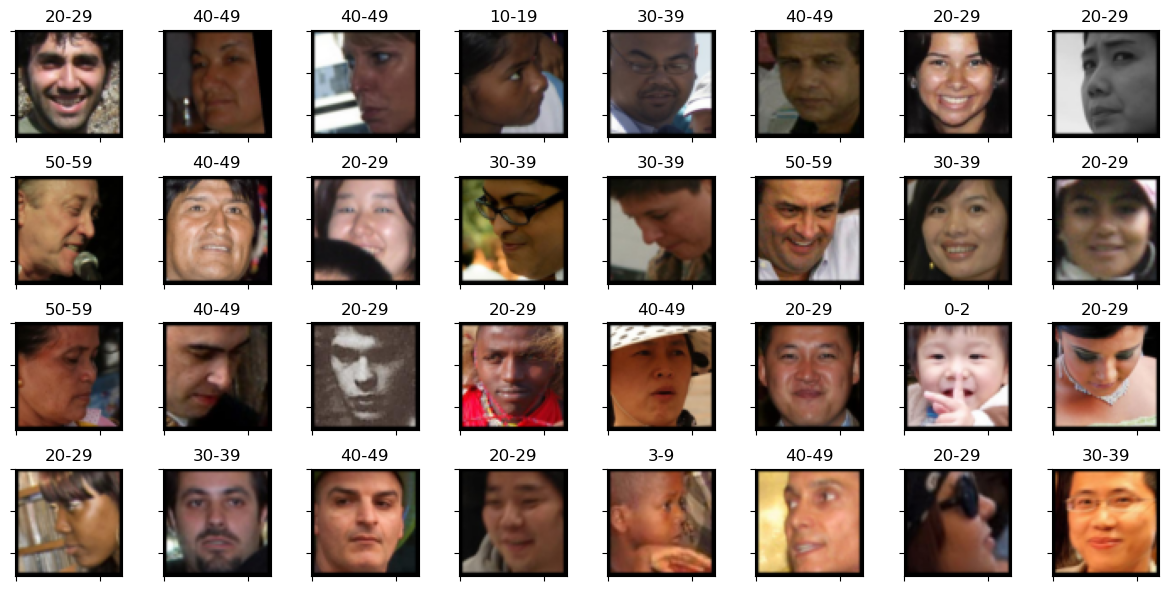

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    transforms.ToTensor(),
    #transforms.to
])


ds_train = FairFace(train_path_csv, data_dir, tsfm)
ds_test = FairFace(test_path_csv, data_dir, tsfm)

# Dataloaders


# Definir la proporción deseada
train_size = int(0.8 * len(ds_train))
valid_size = len(ds_train) - train_size

# Dividir el conjunto de datos en entrenamiento y validación
train_dataset, valid_dataset = random_split(ds_train, [train_size, valid_size])

#cargadores de datos
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

test_dataloader = DataLoader(ds_test, batch_size = BATCH_SIZE, shuffle = True)



# desplegamos un lote de imágenes

x, y = next(iter(train_dataloader))
y = y.unsqueeze(1)
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{ind_a_str[i[0].item()]}' for i in y]
display_batch(x, titles, ROWS, COLS)


Visualicemos las distribuciones de ambos conjuntos de datos

/tmp/ipykernel_757711/1688472489.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(idx_ent, rotation=90)
/tmp/ipykernel_757711/1688472489.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(idx_val, rotation=90)


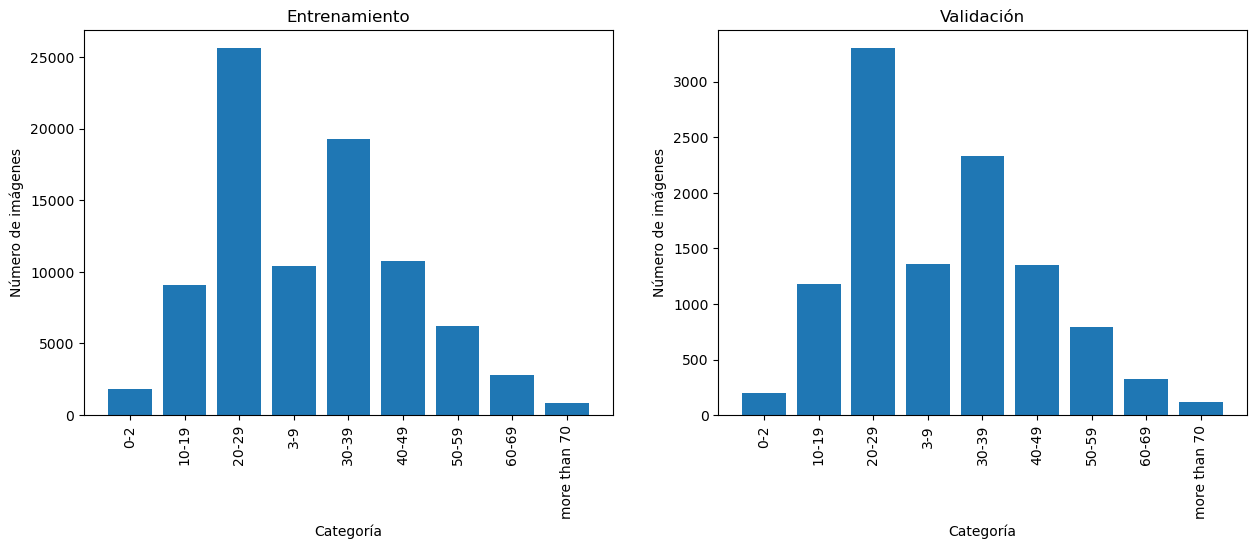

In [ ]:
idx_ent, cuentas_train = np.unique(df_train['age'], return_counts=True)
idx_val, cuentas_test = np.unique(df_test['age'], return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_train)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')


axs[1].bar(x=idx_val, height=cuentas_test)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

# Rotar las etiquetas en el eje x
axs[0].set_xticklabels(idx_ent, rotation=90)
axs[1].set_xticklabels(idx_val, rotation=90)


plt.show()

Existe un desbalance en los datos,pues existen categorias con más datos que otros. Para lidiar con esto utilizaremos un pesado al momento de evaluar. Daremos más peso a las clases con pocos datos:



```
class_weights = [cat1, cat2, cat3, ...]
```


In [ ]:
conteo_categoria = df_train['age'].value_counts()
print(conteo_categoria)


# Calcula los pesos de clases inversamente proporcionales
total_ejemplos = len(df_train)
class_weights = total_ejemplos / (len(conteo_categoria) * conteo_categoria)
class_weights = class_weights.to_list()

20-29           25598
30-39           19250
40-49           10744
3-9             10408
10-19            9103
50-59            6228
60-69            2779
0-2              1792
more than 70      842
Name: age, dtype: int64


In [ ]:
class_weights

[0.3765224713736316,
 0.5006868686868687,
 0.8970795069082486,
 0.9260397984456401,
 1.058796245438012,
 1.5475629772354242,
 3.468233977050098,
 5.378472222222222,
 11.446819741356558]

# 3 Agregar acrecentamiento de datos.

Una estrategia sencilla pero a la vez efectiva para reducir el sobreajuste es el [acrecentamiento de datos](https://en.wikipedia.org/wiki/Data_augmentation), que consiste en generar versiones modificadas de los datos disponibles. Para el caso de clasificación de imágenes, esto puede lograrse aplicando transformaciones que conserven las correspondientes etiquetas (por ej. aleatoriamente voltear las imágenes horizontalmente/verticalmente, recortarlas, rotarlas, etc.). `torchvision` cuenta con varias de estas transformaciones, como `RandomHorizontalFlip` y `RandomResizedCrop` para voltear y para recortar una imagen de forma aleatoria.

El acrecentamiento usualmente solo se realiza con los datos de entrenamiento, por lo que tenemos dos secuencias de transformaciones:

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


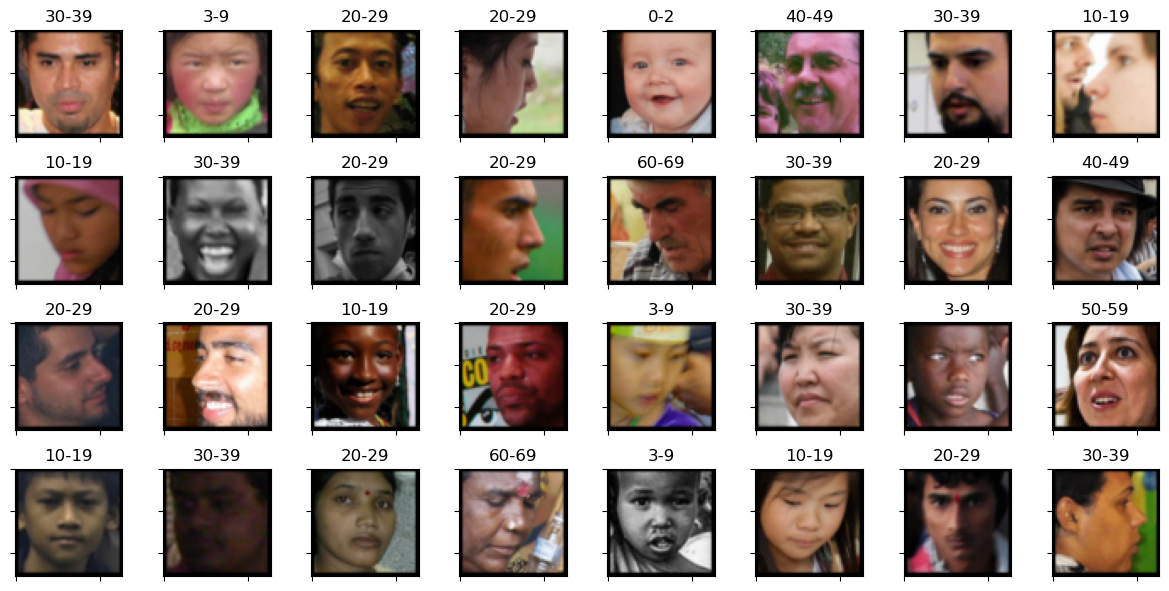

In [ ]:
import torch
from torchvision import datasets, transforms

data_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(64,
                                 scale = (0.85, 1.0),
                                  antialias = True),  # Recorta y redimensiona aleatoriamente
    transforms.RandomHorizontalFlip(),  # Voltea horizontalmente aleatoriamente
    transforms.RandomRotation(10),  # Rota aleatoriamente en un rango de -10 a 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios aleatorios en brillo, contraste, saturación y tono
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Transformación afín aleatoria
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalización
    transforms.ToTensor(),  # Convierte la imagen a tensor

])



data_transforms_test = transforms.Compose([transforms.Resize(64, antialias=True),
                       transforms.ToTensor()])


#Como ya contamos con instancias para los subconjuntos de entrenamiento y prueba, podemos simplemente modificar el valor de la variable `transform`:

#redefinimos las trasnformaciones para cada conjunto
train_dataset.transform = data_transforms_train
valid_dataset.transform = data_transforms_train
ds_test.transform = data_transforms_test

#cargadores de datos
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataloader = DataLoader(ds_test, batch_size = BATCH_SIZE, shuffle = True)

#Visualizamos algunas imágenes con estas transformaciones.

# desplegamos un lote de imágenes
x, y = next(iter(train_dataloader))
y = y.unsqueeze(1)
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{ind_a_str[i[0].item()]}' for i in y]
display_batch(x, titles, ROWS, COLS)

# 4 Funciones para el entrenamiento
Para facilitar el entrenamiento, definimos diversas funciones.



## Guardar _checkpoint_
Podemos guardar el estado del entrenamiento y de un modelo mediante la función `save`.

In [ ]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  th.save(estado_modelo, ckptpath)

## Registrar información para Tensorboard
Para guardar información que pueda visualizarse con Tensorboard, instanciamos la clase `SummaryWriter` del submódulo `tensorboard` del módulo `utils` y escribimos información mediante los distintos métodos disponibles (por ej. `add_scalar`, `add_image`, `add_histogram`, etc.).

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

In [ ]:
!pip install tensorboard

In [ ]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y
  aciertos = th.count_nonzero(cmp)
  return aciertos / cmp.shape[0]



### Paso de entrenamiento
Definimos una función que realiza un paso de entrenamiento, a la cual llamaremos `paso_ent`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- La métrica a evaluar (`metrica`)
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- Una instancia de `Tensor` con el lote de entradas (`X`).
- Una instancia de `Tensor` con el lote de salidas (`y`).

La función obtiene las predicciones del modelo para las entradas, calcula la pérdida, obtiene los gradientes y actualiza todos los parámetros del modelo mediante el optimizador pasado como argumento.

In [ ]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    #perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    perdida_paso = perdida.to('cpu').numpy()


    metricas_paso = metrica(y_hat.cpu(), y.cpu())

  return perdida_paso, metricas_paso

También definimos el ciclo de entrenamiento principal, que llamaremos `entrena`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- La métrica a evaluar (`metrica`)
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- El cargador de datos del subconjunto de entrenamiento (`entdl`).
- El cargador de datos del subconjunto de validación (`valdl`).
- El dispositivo en el que se ejecutará el modelo (`disp`).
- La ruta al archivo donde se guardará el estado del entrenamiento y el modelo (`ckptpath`).
- El número de épocas de entrenamiento (`n_epocas`).
- La ruta al directorio donde se guardará la información para Tensorboard (`tbdir`).

Para cada una de las épocas, va tomando un lote de entradas y salidas a la vez, con los cuales se realiza un paso de entrenamiento.

In [ ]:
import copy

def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          metrica.__name__ + '_ent': np.zeros(n_epocas),
          metrica.__name__ + '_val': np.zeros(n_epocas)}

  tbwriter = SummaryWriter(tbdir)
  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote, ylote) in enumerate(entdl):
      #Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
      #Xlote = Xlote.type(torch.LongTensor)
      #Xlote = Xlote.to(torch.float32)
      Xlote = Xlote.to(torch.float)
      Xlote = Xlote.to(disp)
      ylote = ylote.type(torch.LongTensor)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist['perdida_ent'][e] += perdida_paso
      hist[metrica.__name__ + '_ent'][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with th.no_grad():
      for Xlote,ylote in valdl:
       # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(disp)
        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['perdida_val'][e] += fp(y_hat, ylote)
        hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

    hist['perdida_ent'][e] /=  n_lotes_ent
    hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
    hist['perdida_val'][e] /=  n_lotes_val
    hist[metrica.__name__ + '_val'][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter, e, hist)

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')

  return modelo, mejor_modelo, hist


Para los entrenamientos por transferencia el ciclo de entrenamiento principal, que llamaremos `entrena_transferencia`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`), que se presupone que se encuentra en modo entrenamiento.
- La función de pérdida (`fp`).
- La métrica a evaluar (`metrica`)
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- El cargador de datos del subconjunto de entrenamiento (`entdl`).
- El cargador de datos del subconjunto de validación (`valdl`).
- El dispositivo en el que se ejecutará el modelo (`disp`).
- La ruta al archivo donde se guardará el estado del entrenamiento y el modelo (`ckptpath`).
- El número de épocas de entrenamiento (`n_epocas`).
- La ruta al directorio donde se guardará la información para Tensorboard (`tbdir`).

Para cada una de las épocas, va tomando un lote de entradas y salidas a la vez, con los cuales se realiza un paso de entrenamiento. Para evitar que los estadísticos de las capas de normalización por lotes se actualicen, no se pone la red en modo entrenamiento. Aunque la capa de salida sí se va a actualizar y al poner la red en modo evaluación esta capa también lo hace, el entrenamiento no se verá afectado debido a que su operación es idéntica en ambos modos.

In [ ]:
import copy

def entrena_transferencia(modelo,
                          fp,
                          metrica,
                          opt,
                          entdl,
                          valdl,
                          disp,
                          ckptpath,
                          n_epocas = 10,
                          tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {
    'ent': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      },
    'val': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      }
  }

  tbwriter_ent = SummaryWriter(tbdir + '/ent')
  tbwriter_val = SummaryWriter(tbdir + '/val')

  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    for p, (Xlote,ylote) in enumerate(entdl):
      Xlote = Xlote.to(torch.float)
      Xlote = Xlote.to(disp)
      ylote = ylote.type(torch.LongTensor)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist["ent"]['perdida'][e] += perdida_paso
      hist["ent"][metrica.__name__][e] += metrica_paso

    # bucle de validación
    with th.no_grad():
      for Xlote,ylote in valdl:
        #Xlote = Xlote.to(disp)
        #ylote = ylote.to(disp)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(disp)
        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['val']['perdida'][e] += fp(y_hat, ylote)
        hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent'][metrica.__name__][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val'][metrica.__name__][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['val']['perdida'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter_ent, e, hist['ent'])
    registra_info_tboard(tbwriter_val, e, hist['val'])

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
          f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

  return modelo, mejor_modelo, hist

Modificamos la función entrena_transferencia para que se ponga en modo entrenamiento cuando se ajusten los parámetros y estadísticos.

In [ ]:
def entrena_ajuste_fino(modelo,
                        fp,
                        metrica,
                        opt,
                        entdl,
                        valdl,
                        disp,
                        ckptpath,
                        n_epocas = 10,
                        tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {
    'ent': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      },
    'val': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      }
  }

  tbwriter_ent = SummaryWriter(tbdir + '/ent')
  tbwriter_val = SummaryWriter(tbdir + '/val')

  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote,ylote) in enumerate(entdl):
      Xlote = Xlote.to(torch.float)
      Xlote = Xlote.to(disp)
      ylote = ylote.type(torch.LongTensor)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist["ent"]['perdida'][e] += perdida_paso
      hist["ent"][metrica.__name__][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with th.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(disp)
        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['val']['perdida'][e] += fp(y_hat, ylote)
        hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent'][metrica.__name__][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val'][metrica.__name__][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['val']['perdida'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter_ent, e, hist['ent'])
    registra_info_tboard(tbwriter_val, e, hist['val'])

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
          f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

  return modelo, mejor_modelo, hist

## Función para graficar

In [ ]:
import matplotlib.pyplot as plt

def graficar_entrenamiento(titulo, hist):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
    axs[0].plot(hist['perdida_val'], label='Validación')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Pérdida')
    axs[0].legend()

    axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
    axs[1].plot(hist['exactitud_val'], label='Validación')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Exactitud')
    axs[1].legend()
    plt.show()


In [ ]:
def graficar_entrenamiento2(titulo, hist):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
    axs[0].plot(hist['val']['perdida'], label='Validación')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Pérdida')
    axs[0].legend()

    axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
    axs[1].plot(hist['val']['exactitud'], label='Validación')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Exactitud')
    axs[1].legend()
    fig.suptitle(titulo, fontsize=16)
    plt.show()

# 5 Arquitecturas

## 5.1 ResNet

Ahora vamos a definir una red neuronal convolucional simple con bloques de tipo residual

In [ ]:
class Residual(nn.Module):
  def __init__(self,
               cent,
               csal):
    super(Residual, self).__init__()

    self.conv1 = nn.Conv2d(cent, csal, 3, padding = 'same')
    self.bn1 = nn.BatchNorm2d(csal)
    self.conv2 = nn.Conv2d(csal, csal, 3, padding = 'same')
    self.bn2 = nn.BatchNorm2d(csal)

    if cent != csal:
      self.conv1x1 = nn.Conv2d(cent, csal, 1)
    else:
      self.conv1x1 = None

  def forward(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = nn.functional.relu(y)
    y = self.conv2(y)
    y = self.bn2(y)

    if self.conv1x1:
      x = self.conv1x1(x)

    return nn.functional.relu(x + y)


#Probamos nuestro bloque residual con una imagen:
res = Residual(3, 16)
print(res(th.rand(1, 3, 64, 64)).shape)


torch.Size([1, 16, 64, 64])


Definimos un bloque ResNet con bloques residuales:

In [ ]:
class BloqueResNet(nn.Module):
  def __init__(self,
               cent,
               csal,
               k = 2):
    super(BloqueResNet, self).__init__()

    self.res = [Residual(cent, csal)]
    for i in range(1, k):
      self.res.append(Residual(csal, csal))
    self.res = nn.ModuleList(self.res)

  def forward(self, x):
    for r in self.res:
      x = r(x)
    return x


# Pasamos una imagen por nuestro bloque ResNet para probarlo.


b = BloqueResNet(3, 6)
print(b(th.rand(1, 3, 64, 64)).shape)



torch.Size([1, 6, 64, 64])


### ResNet18

Finalmente definimos nuestra arquitectura ResNet18 usando los bloques ResNet.

In [ ]:
class ResNet18(nn.Module):
  def __init__(self,
               n_clases):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2)
    self.mp1 = nn.MaxPool2d(kernel_size = 3, stride = 2)

    self.b1 = BloqueResNet(64, 64, 2)
    self.b2 = BloqueResNet(64, 128, 2)
    self.b3 = BloqueResNet(128, 256, 2)
    self.b4 = BloqueResNet(256, 512, 2)

    self.gap = nn.AdaptiveAvgPool2d((1, 1))
    self.densa = nn.Linear(512, n_clases)

  def forward(self, x):
    x = self.conv1(x)
    x = self.mp1(x)
    x = self.b1(x)
    x = self.b2(x)
    x = self.b3(x)
    x = self.b4(x)
    x = self.gap(x)
    x = x.flatten(start_dim=1)

    return self.densa(x)



## 5.1 Bloques ConNeXt.
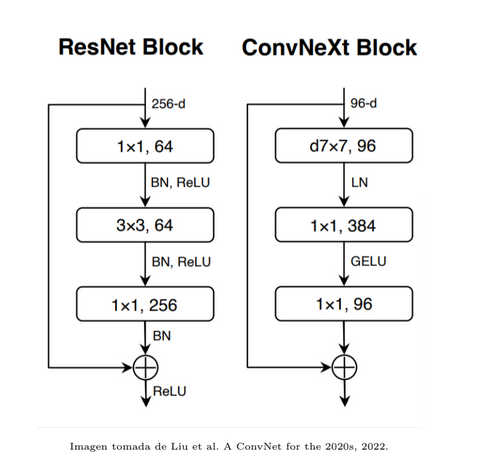

### ConvNeXt.
Ahora vamos a definir una red neuronal convolucional simple con bloques de tipo ConvNeXt:


In [ ]:

class Conv(nn.Module):
  def __init__(self,
               cent,
               csal):
    super(Conv, self).__init__()

    self.conv1 = nn.Conv2d(cent, cent, 7, stride=(1, 1), padding=(3, 3))
    self.ln1 = nn.LayerNorm(cent)
    self.lin1 = nn.Linear(cent, cent*4)
    self.gel = nn.GELU()
    self.lin2 = nn.Linear(cent*4, csal)

    if cent != csal:
      self.conv1x1 = nn.Conv2d(cent, csal, 1)
    else:
      self.conv1x1 = None

  def forward(self, x):
    y = self.conv1(x)
    y = y.permute(0,2,3,1)
    y = self.ln1(y)
    y = self.lin1(y)
    y = self.gel(y)
    y = self.lin2(y)
    y = y.permute(0,3,1,2)

    if self.conv1x1:
      x = self.conv1x1(x)

    return x + y

#Probamos nuestro bloque residual con una imagen:

res = Conv(3, 16)
print(res(th.rand(1, 3, 64, 64)).shape)

#Definimos un bloque ResNet con bloques residuales:

torch.Size([1, 16, 64, 64])


In [ ]:
class BloqueConvxNet(nn.Module):
  def __init__(self,
               cent,
               csal,
               k = 2):
    super(BloqueConvxNet, self).__init__()

    self.res = [Conv(cent, csal)]
    for i in range(1, k):
      self.res.append(Conv(csal, csal))
    self.res = nn.ModuleList(self.res)

  def forward(self, x):
    for r in self.res:
      x = r(x)
    return x


## ConvxNet18

In [ ]:
class ConvxNet18(nn.Module):
  def __init__(self,
               n_clases):
    super(ConvxNet18, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2)
    self.mp1 = nn.MaxPool2d(kernel_size = 3, stride = 2)

    self.b1 = BloqueConvxNet(64, 64, 2)
    self.b2 = BloqueConvxNet(64, 128, 2)
    self.b3 = BloqueConvxNet(128, 256, 2)
    self.b4 = BloqueConvxNet(256, 512, 2)

    self.gap = nn.AdaptiveAvgPool2d((1, 1))
    self.densa = nn.Linear(512, n_clases)

  def forward(self, x):
    x = self.conv1(x)
    x = self.mp1(x)
    x = self.b1(x)
    x = self.b2(x)
    x = self.b3(x)
    x = self.b4(x)
    x = self.gap(x)
    x = x.flatten(start_dim=1)

    return self.densa(x)


# Entrenamiento

In [ ]:
 save_path = os.path.join(data_dir, LOGDIR)
 save_path

'/home/carmen/DL/fairface/logs/'

In [ ]:
from sklearn.metrics import f1_score


## ConvxNet18

In [ ]:
resnet = ConvxNet18(len(ind_a_str))
resnet.to(device)
N_EPOCAS = 50
class_weights = torch.tensor(class_weights).to(device)

perdida = nn.CrossEntropyLoss(weight= None,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(resnet.parameters(),
           lr=0.001)

resnet, mejor_resnet, hist = entrena(resnet,
                                     perdida,
                                     exactitud,
                                     opt,
                                     train_dataloader,
                                     valid_dataloader,
                                     device,
                                     save_path + 'ConvxNet18.pt',
                                     n_epocas= N_EPOCAS,
                                     tbdir = LOGDIR)



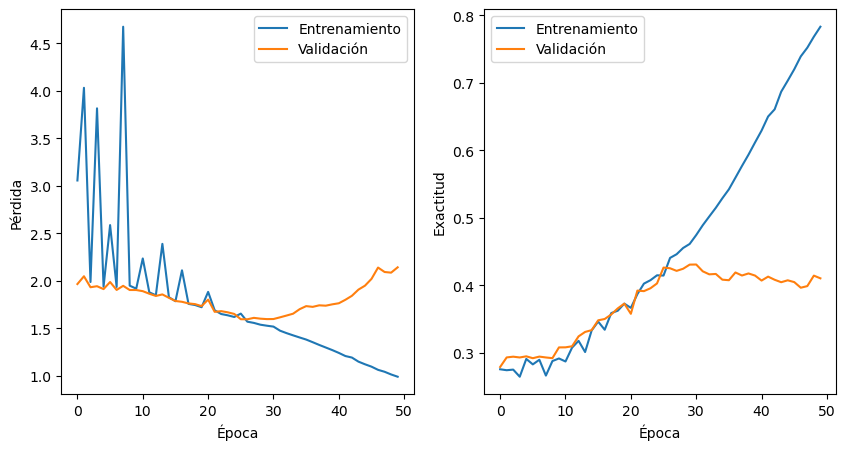

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

## ConvxNet18 + pesado de clases (50 epocas)

In [ ]:
resnet = ConvxNet18(len(ind_a_str))
resnet.to(device)
N_EPOCAS = 50
class_weights = torch.tensor(class_weights).to(device)

perdida = nn.CrossEntropyLoss(weight= class_weights,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(resnet.parameters(),
           lr=0.001)

resnet, mejor_resnet, hist = entrena(resnet,
                                     perdida,
                                     exactitud,
                                     opt,
                                     train_dataloader,
                                     valid_dataloader,
                                     device,
                                     save_path + 'ConvxNet18_pesada.pt',
                                     n_epocas= N_EPOCAS,
                                     tbdir = LOGDIR)



/tmp/ipykernel_732652/545097781.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights).to(device)



Época 0: Perdida(E) = 2.335, exactitud(E) = 0.096, Perdida(V) = 2.135, exactitud(V) = 0.095

Época 1: Perdida(E) = 6.163, exactitud(E) = 0.096, Perdida(V) = 2.138, exactitud(V) = 0.098

Época 2: Perdida(E) = 2.316, exactitud(E) = 0.092, Perdida(V) = 2.143, exactitud(V) = 0.091

Época 3: Perdida(E) = 2.666, exactitud(E) = 0.098, Perdida(V) = 2.140, exactitud(V) = 0.091

Época 4: Perdida(E) = 2.145, exactitud(E) = 0.090, Perdida(V) = 2.146, exactitud(V) = 0.092

Época 5: Perdida(E) = 5.389, exactitud(E) = 0.102, Perdida(V) = 2.146, exactitud(V) = 0.092

Época 6: Perdida(E) = 2.175, exactitud(E) = 0.102, Perdida(V) = 2.148, exactitud(V) = 0.063

Época 7: Perdida(E) = 2.213, exactitud(E) = 0.098, Perdida(V) = 2.126, exactitud(V) = 0.098

Época 8: Perdida(E) = 3.681, exactitud(E) = 0.100, Perdida(V) = 2.381, exactitud(V) = 0.022

Época 9: Perdida(E) = 2.229, exactitud(E) = 0.095, Perdida(V) = 2.372, exactitud(V) = 0.020

Época 10: Perdida(E) = 2.218, exactitud(E) = 0.101, Perdida(V) = 2.12

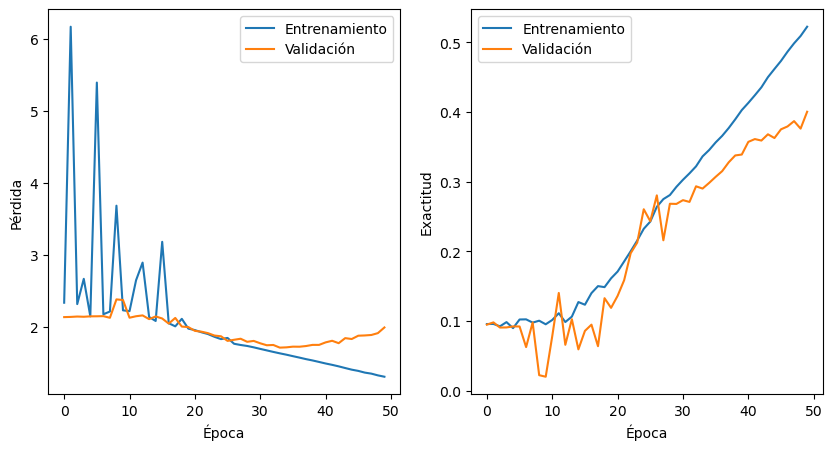

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

## ConvxNet18 + pesado de clases (200 epocas)

In [ ]:
resnet = ConvxNet18(len(ind_a_str))
resnet.to(device)
N_EPOCAS = 200
class_weights = torch.tensor(class_weights).to(device)

perdida = nn.CrossEntropyLoss(weight= class_weights,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(resnet.parameters(),
           lr=0.001)

resnet, mejor_resnet, hist = entrena(resnet,
                                     perdida,
                                     exactitud,
                                     opt,
                                     train_dataloader,
                                     valid_dataloader,
                                     device,
                                     save_path + 'ConvxNet18_pesada2.pt',
                                     n_epocas= N_EPOCAS,
                                     tbdir = LOGDIR)



/tmp/ipykernel_732652/3428172403.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights).to(device)



Época 0: Perdida(E) = 8.286, exactitud(E) = 0.101, Perdida(V) = 2.295, exactitud(V) = 0.026

Época 1: Perdida(E) = 2.562, exactitud(E) = 0.098, Perdida(V) = 2.221, exactitud(V) = 0.103

Época 2: Perdida(E) = 2.172, exactitud(E) = 0.089, Perdida(V) = 2.145, exactitud(V) = 0.093

Época 3: Perdida(E) = 3.838, exactitud(E) = 0.089, Perdida(V) = 2.138, exactitud(V) = 0.096

Época 4: Perdida(E) = 2.152, exactitud(E) = 0.085, Perdida(V) = 2.142, exactitud(V) = 0.079

Época 5: Perdida(E) = 2.154, exactitud(E) = 0.091, Perdida(V) = 2.139, exactitud(V) = 0.098

Época 6: Perdida(E) = 2.828, exactitud(E) = 0.102, Perdida(V) = 2.114, exactitud(V) = 0.081

Época 7: Perdida(E) = 2.142, exactitud(E) = 0.097, Perdida(V) = 2.106, exactitud(V) = 0.101

Época 8: Perdida(E) = 2.121, exactitud(E) = 0.104, Perdida(V) = 2.109, exactitud(V) = 0.092

Época 9: Perdida(E) = 4.469, exactitud(E) = 0.108, Perdida(V) = 2.171, exactitud(V) = 0.133

Época 10: Perdida(E) = 2.440, exactitud(E) = 0.104, Perdida(V) = 89.8

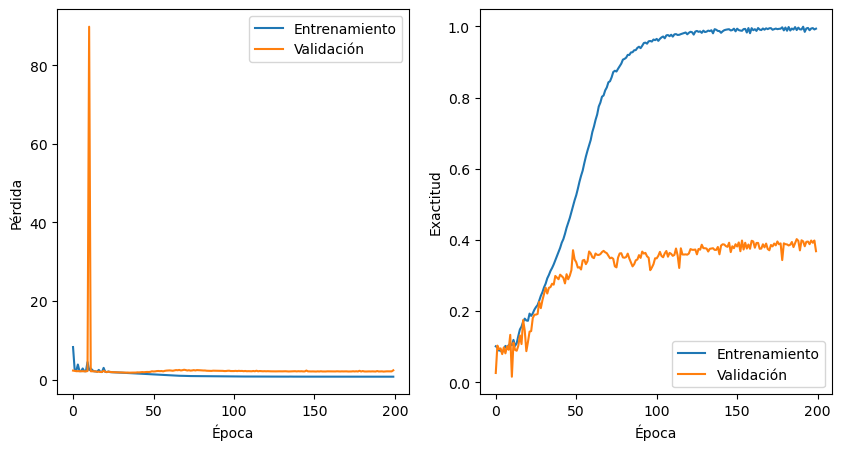

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

## Predicción sobre conjunto de prueba

Es claro que la red anterior tiene sobre ajuste, después de 50 épocas el rendimiento en validación se mantiene constante, en cambio en entrenamiento sigue mejorando. Por otro lado, observemos que el pesado de clase no mejora mucho el desempeño de nuestra alcanzando un exactitud(E) = 0.522,  exactitud(V) = 0.400 en 50 epocas, mientras que en el entrenamiento sin pesado se alcanza al rededor de un 4.5 en entrenamiento, así como en en validación en 30 épocas. Por lo que elegiremos como mejor modelo el primero,para hacer nuestra predicción sobre el conjunto de prueba:

In [ ]:
checkpoint = torch.load('/home/carmen/DL/fairface/logs/ConvxNet18.pt')

epoca = checkpoint['epoch']
modelo_state_dict = checkpoint['model_state_dict']

modelo = ConvxNet18(len(ind_a_str))

modelo.load_state_dict(modelo_state_dict)

modelo.eval()


NameError: name 'torch' is not defined

In [ ]:
modelo.to(device)
with th.no_grad():
    for Xlote,ylote in test_dataloader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
    #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = modelo(Xlote)
        y_hat = y_hat.to(device)
        metrica_test = exactitud(y_hat, ylote)

metrica_test

tensor(0.2000, device='cuda:0')

Conclusión: está horrible. Probemos otra red.

## ResNet18

Probemos la ResNet18 para la misma tarea

In [ ]:
resnet = ResNet18(len(ind_a_str))
resnet.to(device)

N_EPOCAS = 20
class_weights = torch.tensor(class_weights).to(device)


opt = Adam(resnet.parameters(),
           lr=0.001)

perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.1)


resnet, mejor_resnet, hist = entrena(resnet,
                                     perdida,
                                     exactitud,
                                     opt,
                                     train_dataloader,
                                     valid_dataloader,
                                     device,
                                     save_path + 'ResNet18.pt',
                                     n_epocas= N_EPOCAS,
                                     tbdir = LOGDIR)



/tmp/ipykernel_759584/2985777776.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights).to(device)



Época 0: Perdida(E) = 1.859, exactitud(E) = 0.320, Perdida(V) = 1.792, exactitud(V) = 0.342

Época 1: Perdida(E) = 1.706, exactitud(E) = 0.376, Perdida(V) = 1.674, exactitud(V) = 0.390

Época 2: Perdida(E) = 1.627, exactitud(E) = 0.410, Perdida(V) = 1.619, exactitud(V) = 0.414

Época 3: Perdida(E) = 1.569, exactitud(E) = 0.432, Perdida(V) = 1.684, exactitud(V) = 0.389

Época 4: Perdida(E) = 1.528, exactitud(E) = 0.454, Perdida(V) = 1.632, exactitud(V) = 0.422

Época 5: Perdida(E) = 1.492, exactitud(E) = 0.471, Perdida(V) = 1.500, exactitud(V) = 0.467

Época 6: Perdida(E) = 1.461, exactitud(E) = 0.486, Perdida(V) = 1.480, exactitud(V) = 0.475

Época 7: Perdida(E) = 1.435, exactitud(E) = 0.500, Perdida(V) = 1.479, exactitud(V) = 0.468

Época 8: Perdida(E) = 1.412, exactitud(E) = 0.509, Perdida(V) = 1.582, exactitud(V) = 0.444

Época 9: Perdida(E) = 1.389, exactitud(E) = 0.523, Perdida(V) = 1.445, exactitud(V) = 0.491

Época 10: Perdida(E) = 1.369, exactitud(E) = 0.531, Perdida(V) = 1.52

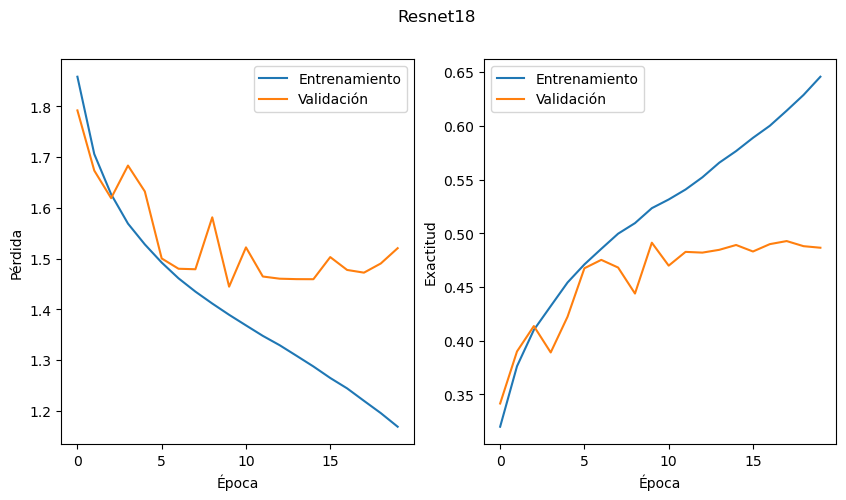

In [ ]:
graficar_entrenamiento("Resnet18", hist)

Dado que este modelo es mejor harémos predicciones sobre él en el conjunto de prueba:


In [ ]:
#resnet.to(device)
with th.no_grad():
    for Xlote,ylote in test_dataloader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
    #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = resnet(Xlote)
        y_hat = y_hat.to(device)
        metrica_test = exactitud(y_hat, ylote)

metrica_test

tensor(0.6000, device='cuda:0')

Efectivamnente tiene un mejor desempeño que con los bloques ConvNext, alcanzando un 0.6 de exactitud para este problema. Podemos observar que los pesados de clase no mejoran los entremaientos y en la mayoría de ellos se observa un sobreajuste.

# 6 Aprendizaje por transferencia

In [ ]:
import torchvision as tv

tv.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

## ResNet50

In [ ]:
n_clases = len(ind_a_str)

resnet50 = tv.models.resnet50() # por defecto weights = None

#Si deseamos instanciarla con pesos y sesgos preentrenados en ImageNet:

resnet50 = tv.models.resnet50(weights = tv.models.ResNet50_Weights.IMAGENET1K_V1)

#Congelamos toda la red para evitar que se realice diferenciación automática y se actualicen sus pesos y sesgos.

for p in resnet50.parameters():
    p.requires_grad = False

#Para poder usar esta red en nuestra tarea es necesario cambiar la capa de salida. Para ello asignamos una nueva instancia de `Linear`, tomando en cuenta las características de nuestra tarea.

#resnet50.fc = nn.Linear(2048, n_clases)

#La capa softmax asignará una probabilidad a cada clase y permitirá que el modelo
# #realice una clasificación de una instancia en una de las clases.

resnet50.fc = nn.Sequential(
    nn.Linear(2048, n_clases),
    nn.Softmax(dim=1)
)


In [ ]:
from torch.optim import Adam

resnet50.to(device)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(resnet50.parameters(),
           lr=0.001)
N_EPOCAS = 30
resnet50.eval()
resnet50, mejor_resnet50, hist = entrena_transferencia(resnet50,
                                                        perdida,
                                                        exactitud,
                                                        opt,
                                                        train_dataloader,
                                                        valid_dataloader,
                                                        device,
                                                        save_path + 'resnet50_transferencia.pt',
                                                        n_epocas= N_EPOCAS,
                                                        tbdir = LOGDIR)



Época 0: Perdida(E) = 1.825, exactitud(E) = 0.340, Perdida(V) = 1.698, exactitud(V) = 0.371

Época 1: Perdida(E) = 1.561, exactitud(E) = 0.411, Perdida(V) = 1.537, exactitud(V) = 0.420

Época 2: Perdida(E) = 1.502, exactitud(E) = 0.430, Perdida(V) = 1.495, exactitud(V) = 0.432

Época 3: Perdida(E) = 1.466, exactitud(E) = 0.442, Perdida(V) = 1.473, exactitud(V) = 0.436

Época 4: Perdida(E) = 1.434, exactitud(E) = 0.452, Perdida(V) = 1.439, exactitud(V) = 0.448

Época 5: Perdida(E) = 1.405, exactitud(E) = 0.464, Perdida(V) = 1.478, exactitud(V) = 0.436

Época 6: Perdida(E) = 1.378, exactitud(E) = 0.470, Perdida(V) = 1.429, exactitud(V) = 0.454

Época 7: Perdida(E) = 1.357, exactitud(E) = 0.479, Perdida(V) = 1.404, exactitud(V) = 0.468

Época 8: Perdida(E) = 1.334, exactitud(E) = 0.488, Perdida(V) = 1.385, exactitud(V) = 0.466

Época 9: Perdida(E) = 1.316, exactitud(E) = 0.495, Perdida(V) = 1.391, exactitud(V) = 0.474

Época 10: Perdida(E) = 1.298, exactitud(E) = 0.502, Perdida(V) = 1.38

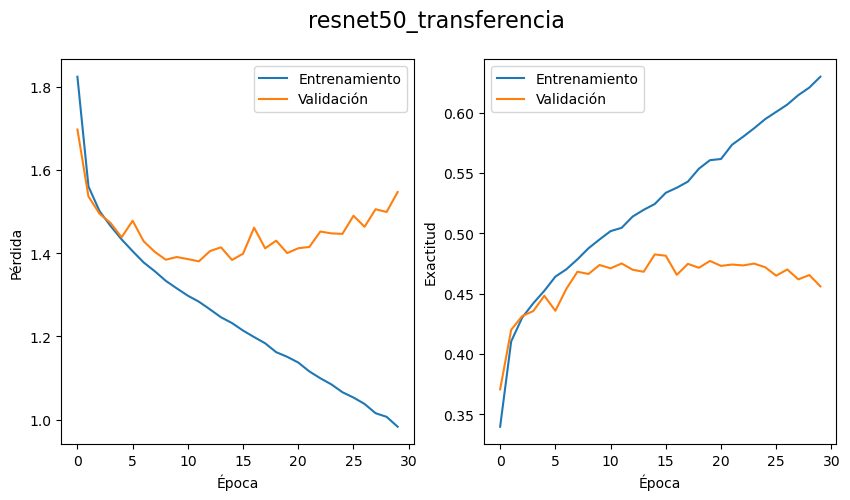

In [ ]:
graficar_entrenamiento2('resnet50_transferencia', hist)

## Transferencia + Ajuste fino
Una vez entrenada la capa de salida para la tarea objetivo, es común ajustar los parámetros y estadísticos de toda la red con una tasa de aprendizaje más pequeña. A este proceso se le llama ajuste fino. Modificamos la función `entrena_transferencia` para que se ponga en modo entrenamiento cuando se ajusten los parámetros y estadísticos.

Para que se calculen los gradientes y actualicen los parámetros de toda la red, debemos volver a poner el atributo `requires_grad` de todos sus parámetros a verdadero.

In [ ]:
for p in resnet50.parameters():
    p.requires_grad = True

In [ ]:
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)

opt = Adam(resnet50.parameters(),
           lr=0.0001)

N_EPOCAS = 50
resnet50, mejor_resnet50, hist = entrena_ajuste_fino(resnet50,
                                                        perdida,
                                                        exactitud,
                                                        opt,
                                                        train_dataloader,
                                                        valid_dataloader,
                                                        device,
                                                        save_path + 'resnet50_transferencia_fine_tunning.pt',
                                                        n_epocas= N_EPOCAS,
                                                        tbdir = LOGDIR)



Época 0: Perdida(E) = 1.890, exactitud(E) = 0.388, Perdida(V) = 1.554, exactitud(V) = 0.410

Época 1: Perdida(E) = 1.489, exactitud(E) = 0.434, Perdida(V) = 1.455, exactitud(V) = 0.449

Época 2: Perdida(E) = 1.398, exactitud(E) = 0.465, Perdida(V) = 1.396, exactitud(V) = 0.463

Época 3: Perdida(E) = 1.329, exactitud(E) = 0.489, Perdida(V) = 1.365, exactitud(V) = 0.481

Época 4: Perdida(E) = 1.274, exactitud(E) = 0.509, Perdida(V) = 1.379, exactitud(V) = 0.466

Época 5: Perdida(E) = 1.225, exactitud(E) = 0.528, Perdida(V) = 1.360, exactitud(V) = 0.483

Época 6: Perdida(E) = 1.180, exactitud(E) = 0.548, Perdida(V) = 1.361, exactitud(V) = 0.486

Época 7: Perdida(E) = 1.134, exactitud(E) = 0.568, Perdida(V) = 1.362, exactitud(V) = 0.488

Época 8: Perdida(E) = 1.085, exactitud(E) = 0.585, Perdida(V) = 1.374, exactitud(V) = 0.488

Época 9: Perdida(E) = 1.034, exactitud(E) = 0.610, Perdida(V) = 1.428, exactitud(V) = 0.482

Época 10: Perdida(E) = 0.980, exactitud(E) = 0.633, Perdida(V) = 1.47

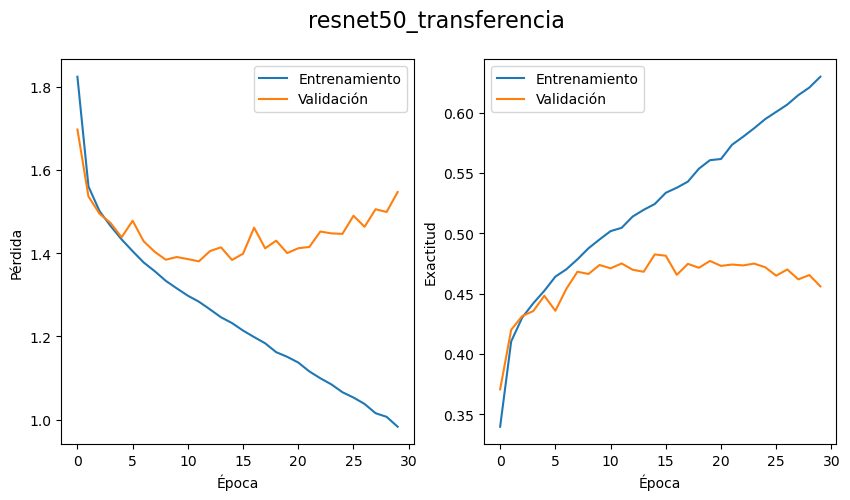

In [ ]:
graficar_entrenamiento2('resnet50_transferencia_fine_tunning', hist)

A partir de las 7 epocas aproximadamente comienza un sobreajuste, no es un buen modelo pues no pasa del 0.45 de exactitud.

#Ajuste fino desde el principio

In [ ]:
resnet50 = tv.models.resnet50(weights = tv.models.ResNet50_Weights.IMAGENET1K_V1)

resnet50.to(device)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(resnet50.parameters(),
           lr=0.0001)

resnet50, mejor_resnet50, hist = entrena_transferencia(resnet50,
                                                        perdida,
                                                        exactitud,
                                                        opt,
                                                        train_dataloader,
                                                        valid_dataloader,
                                                        device,
                                                        save_path + 'resnet50_ft.pt',
                                                        n_epocas= N_EPOCAS,
                                                        tbdir = LOGDIR)


Época 0: Perdida(E) = 1.610, exactitud(E) = 0.434, Perdida(V) = 1.342, exactitud(V) = 0.492

Época 1: Perdida(E) = 1.249, exactitud(E) = 0.519, Perdida(V) = 1.281, exactitud(V) = 0.497

Época 2: Perdida(E) = 1.126, exactitud(E) = 0.570, Perdida(V) = 1.254, exactitud(V) = 0.529

Época 3: Perdida(E) = 0.988, exactitud(E) = 0.632, Perdida(V) = 1.304, exactitud(V) = 0.513

Época 4: Perdida(E) = 0.817, exactitud(E) = 0.711, Perdida(V) = 1.397, exactitud(V) = 0.522

Época 5: Perdida(E) = 0.628, exactitud(E) = 0.799, Perdida(V) = 1.590, exactitud(V) = 0.513

Época 6: Perdida(E) = 0.481, exactitud(E) = 0.861, Perdida(V) = 1.872, exactitud(V) = 0.500

Época 7: Perdida(E) = 0.396, exactitud(E) = 0.899, Perdida(V) = 1.937, exactitud(V) = 0.495

Época 8: Perdida(E) = 0.347, exactitud(E) = 0.918, Perdida(V) = 2.155, exactitud(V) = 0.501

Época 9: Perdida(E) = 0.320, exactitud(E) = 0.929, Perdida(V) = 2.252, exactitud(V) = 0.497


In [ ]:
hist.keys()

dict_keys(['ent', 'val'])

In [ ]:
hist['val']

{'perdida': array([1.34212667, 1.28070956, 1.25372191, 1.30416741, 1.39653451,
        1.58960557, 1.87160631, 1.93654277, 2.15509314, 2.25237891]),
 'exactitud': array([0.49164364, 0.49688074, 0.52901705, 0.51281075, 0.52182322,
        0.5129834 , 0.50008059, 0.49536144, 0.50113949, 0.49709943])}

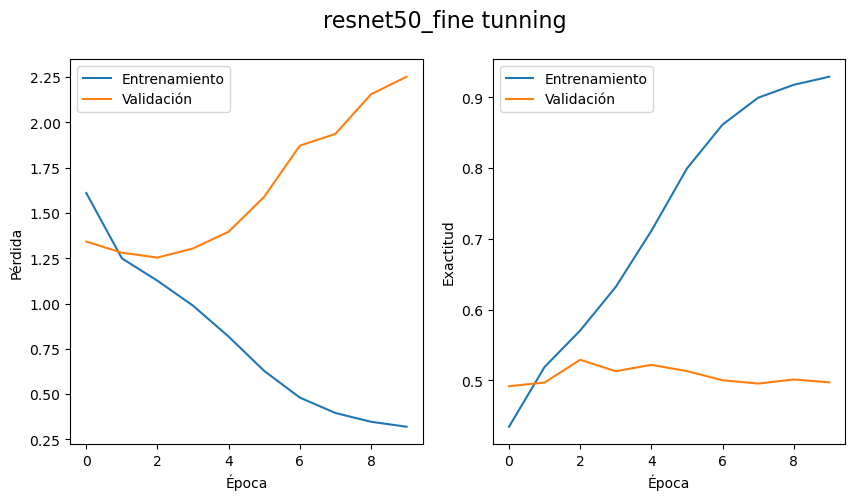

In [ ]:
graficar_entrenamiento2('resnet50_fine tunning', hist)

Hay un claro sobreajuste en el modelo anterior. Por lo que seguimos conservando como mejor modelo la resnet18 que fue evaluda anteriormente.